# SBRC Pandapower Power Flow - Unbalanced Network with MPC Simulation Results

Notebook for obtaining distribution network sensitivities fro  SBRC microgrid via linear regression

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import pandapower as pp

### Import SBRC network data

In [84]:
eco_drh = pd.read_csv('Results/Ecomode_20min_DRH_3-11-2020_7am_6pm.csv', index_col=0)
eco_ifh = pd.read_csv('Results/Ecomode_20min_IFH_3-11-2020_7am_6pm.csv', index_col=0)
eco_sb1 = pd.read_csv('Results/Ecomode_20min_SBRC_P1_3-11-2020_7am_6pm.csv', index_col=0)
eco_sb2 = pd.read_csv('Results/Ecomode_20min_SBRC_P2_3-11-2020_7am_6pm.csv', index_col=0)
eco_sb3 = pd.read_csv('Results/Ecomode_20min_SBRC_P3_3-11-2020_7am_6pm.csv', index_col=0)

In [85]:
eco = pd.DataFrame(index=eco_drh.index[0:72])
eco['DR_Pa'] = eco_drh['p_im'] + eco_drh['p_ex']
eco['IF_Pc'] = eco_ifh['p_im'] + eco_ifh['p_ex']
eco['SB_Pa'] = eco_sb1['p_im'] + eco_sb1['p_ex']
eco['SB_Pb'] = eco_sb2['p_im'] + eco_sb2['p_ex']
eco['SB_Pc'] = eco_sb3['p_im'] + eco_sb3['p_ex']
eco.index = pd.to_datetime((eco.index), format='%Y/%m/%d %H:%M:%S')
eco = eco.resample('5min').interpolate('linear')

In [86]:
vr_drh = pd.read_csv('Results/VRmode_20min_DRH_3-11-2020_7am_6pm.csv', index_col=0)
vr_ifh = pd.read_csv('Results/VRmode_20min_IFH_3-11-2020_7am_6pm.csv', index_col=0)
vr_sb1 = pd.read_csv('Results/VRmode_20min_SBRC_P1_3-11-2020_7am_6pm.csv', index_col=0)
vr_sb2 = pd.read_csv('Results/VRmode_20min_SBRC_P2_3-11-2020_7am_6pm.csv', index_col=0)
vr_sb3 = pd.read_csv('Results/VRmode_20min_SBRC_P3_3-11-2020_7am_6pm.csv', index_col=0)

In [87]:
vr = pd.DataFrame(index=vr_drh.index[0:72])
vr['DR_Pa'] = vr_drh['p_im'] + vr_drh['p_ex']
vr['IF_Pc'] = vr_ifh['p_im'] + vr_ifh['p_ex']
vr['SB_Pa'] = vr_sb1['p_im'] + vr_sb1['p_ex']
vr['SB_Pb'] = vr_sb2['p_im'] + eco_sb2['p_ex']
vr['SB_Pc'] = vr_sb3['p_im'] + eco_sb3['p_ex']
vr.index = pd.to_datetime((vr.index), format='%Y/%m/%d %H:%M:%S')
vr = vr.resample('5min').interpolate('linear')

In [88]:
kiosk = pd.read_csv('CSV/Camp East Kiosk - Hioki PW3198 30sec 20201019 to 20201123 with n.CSV')
kiosk.index = pd.to_datetime((kiosk['Date']+' '+kiosk['Time']), format='%Y/%m/%d %H:%M:%S')
kiosk = kiosk.resample('5min').mean()

## Create Network Model

In [89]:
def time_series_powerflow(scale, df):
    
    sim_results = pd.DataFrame(index=df.index, columns=['SB_Va', 'SB_Vb', 'SB_Vc', 'IF_Vc', 'DR_Va'])

    for i,idx in enumerate(sim_results.index):

        net = pp.create_empty_network(sn_mva=100)

        cable_25mm = dict(r_ohm_per_km=0.884,
                      x_ohm_per_km=0.0973,
                      c_nf_per_km=0.0,
                      r0_ohm_per_km=0.884,
                      x0_ohm_per_km=0.0973,
                      c0_nf_per_km=0.0,
                      max_i_ka=0.09,
                     )

        cable_95mm = dict(r_ohm_per_km=0.193,
                          x_ohm_per_km=0.09,
                          c_nf_per_km=0.0,
                          r0_ohm_per_km=0.772,
                          x0_ohm_per_km=0.36,
                          c0_nf_per_km=0.0,
                          max_i_ka=0.244,
                         )

        cable_240mm = dict(r_ohm_per_km=0.0754/2,
                          x_ohm_per_km=0.0855/2,
                          c_nf_per_km=0.0,
                          r0_ohm_per_km=0.3016/2,
                          x0_ohm_per_km=0.342/2,
                          c0_nf_per_km=0.0,
                          max_i_ka=0.426,
                         )

        pp.create_std_type(net, cable_25mm, '25mm')
        pp.create_std_type(net, cable_95mm, '95mm')
        pp.create_std_type(net, cable_240mm, '240mm')


        b1 = pp.create_bus(net, vn_kv=0.4, name='LV-TX', geodata=(-34.399961,150.898769))
        b2 = pp.create_bus(net, vn_kv=0.4, name='SBRC',geodata=(-34.400124,150.899592))
        b3 = pp.create_bus(net, vn_kv=0.4, name='PILLAR',geodata=(-34.401032,150.897985))
        b4 = pp.create_bus(net, vn_kv=0.4, name='IFH',geodata=(-34.400898,150.897876))
        b5 = pp.create_bus(net, vn_kv=0.4, name='DRH',geodata=(-34.400762,150.897466))

        pp.create_line(net, from_bus=b1, to_bus=b2, length_km=0.1, name="Line1",std_type='240mm') 
        pp.create_line(net, from_bus=b2, to_bus=b3, length_km=0.3, name="Line2",std_type='95mm') 
        pp.create_line(net, from_bus=b3, to_bus=b4, length_km=0.05, name="Line3",std_type='25mm') 
        pp.create_line(net, from_bus=b3, to_bus=b5, length_km=0.08, name="Line4",std_type='25mm')

        pp.create_ext_grid(net, vm_pu=kiosk.loc[idx]['AvgUrms1']/230, bus=b1, s_sc_max_mva=10000, rx_max=0.1)
        net.ext_grid["r0x0_max"] = 0.1
        net.ext_grid["x0x_max"] = 1.0


        pp.create_asymmetric_load(net, bus=b2, p_a_mw=(df.loc[idx]['SB_Pa']/1000000), q_a_mvar=(0/1000000), 
                                               p_b_mw=(df.loc[idx]['SB_Pb']/1000000), q_b_mvar=(0/1000000),
                                               p_c_mw=(df.loc[idx]['SB_Pc']/1000000), q_c_mvar=(0/1000000), name="SBRC_Load")
        pp.create_asymmetric_load(net, bus=b4, p_c_mw=(df.loc[idx]['IF_Pc']/1000000), q_c_mvar=(0/1000000), name='IFH_Load')
        pp.create_asymmetric_load(net, bus=b5, p_a_mw=(df.loc[idx]['DR_Pa']/1000000)*scale, q_a_mvar=(0/1000000), name='DRH_Load')

        pp.add_zero_impedance_parameters(net)
        pp.runpp_3ph(net, numba=False)

        res = net.res_bus_3ph

        #print(res)

        sim_results.loc[idx,'SB_Va'] = res.loc[1]['vm_a_pu']*230
        sim_results.loc[idx,'SB_Vb'] = res.loc[1]['vm_b_pu']*230
        sim_results.loc[idx,'SB_Vc'] = res.loc[1]['vm_c_pu']*230
        sim_results.loc[idx,'DR_Va'] = res.loc[4]['vm_a_pu']*230
        sim_results.loc[idx,'IF_Vc'] = res.loc[3]['vm_c_pu']*230
        
    return sim_results
    

In [90]:
def plot_measured_actual(volts_before, volts_after, bus_volts):
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Time')
    ax1.set_ylabel('kW')
    #ax1.set_ylim(-7,11)
#ax1.plot(volts_df.index, mg.loc[sim_date][bus_volts], linewidth=1, label='MEASURED')
#     ax1.plot(volts_df.index, mg.loc[sim_date]['TX_Va'], linewidth=1, label='MEASURED')
#     ax1.plot(volts_df.index, mg.loc[sim_date]['SB_Va'], linewidth=1, label='MEASURED')
    ax1.plot(volts_before.index, volts_before[bus_volts], color='blue', linewidth=1, label='Before')
    ax1.plot(volts_after.index, volts_after[bus_volts], color='Red', linewidth=1, label='Before')
    ax1.legend(loc="upper left")
    ax1.grid()
    fig.set_figheight(6)
    fig.set_figwidth(9)
    plt.show()

In [91]:
volts_before = time_series_powerflow(scale=1, df=eco)

In [92]:
volts_after = time_series_powerflow(scale=1, df=vr)

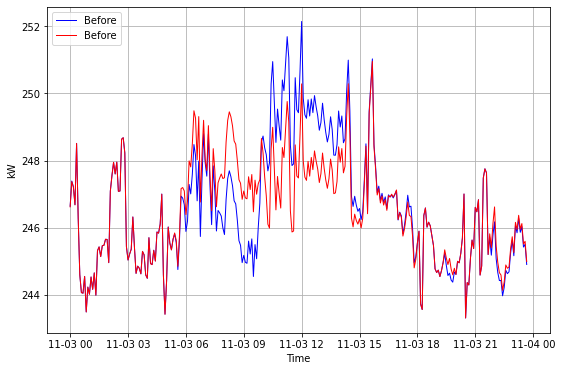

In [94]:
plot_measured_actual(volts_before, volts_after, 'IF_Vc')

In [ ]:
#volts_after = time_series_powerflow(scale=1.02)

In [ ]:
delta_v = volts_before - volts_after

In [ ]:
delta_p_dr = mg.loc[sim_date]['DR_Pa'] - (mg.loc[sim_date]['DR_Pa']*1.02)

In [ ]:
plot_measured_actual(volts_before, bus_volts='DR_Va')

# Calculate Sensitivities with Fixed Network state

The following function determines the network state with only 

In [ ]:
def sensitivity_calc(scale):
    
    dr_fake_load = np.linspace(-20000,20000, num=288)
    
    sim_results = pd.DataFrame(index=mg.loc[sim_date].index, columns=['SB_Va', 'SB_Vb', 'SB_Vc', 'IF_Vc', 'DR_Va'])

    for i,idx in enumerate(sim_results.index):

        net = pp.create_empty_network(sn_mva=100)

        cable_25mm = dict(r_ohm_per_km=0.884,
                      x_ohm_per_km=0.0973,
                      c_nf_per_km=0.0,
                      r0_ohm_per_km=0.884,
                      x0_ohm_per_km=0.0973,
                      c0_nf_per_km=0.0,
                      max_i_ka=0.09,
                     )

        cable_95mm = dict(r_ohm_per_km=0.193,
                          x_ohm_per_km=0.09,
                          c_nf_per_km=0.0,
                          r0_ohm_per_km=0.772,
                          x0_ohm_per_km=0.36,
                          c0_nf_per_km=0.0,
                          max_i_ka=0.244,
                         )

        cable_240mm = dict(r_ohm_per_km=0.0754/2,
                          x_ohm_per_km=0.0855/2,
                          c_nf_per_km=0.0,
                          r0_ohm_per_km=0.3016/2,
                          x0_ohm_per_km=0.342/2,
                          c0_nf_per_km=0.0,
                          max_i_ka=0.426,
                         )

        pp.create_std_type(net, cable_25mm, '25mm')
        pp.create_std_type(net, cable_95mm, '95mm')
        pp.create_std_type(net, cable_240mm, '240mm')


        b1 = pp.create_bus(net, vn_kv=0.4, name='LV-TX', geodata=(-34.399961,150.898769))
        b2 = pp.create_bus(net, vn_kv=0.4, name='SBRC',geodata=(-34.400124,150.899592))
        b3 = pp.create_bus(net, vn_kv=0.4, name='PILLAR',geodata=(-34.401032,150.897985))
        b4 = pp.create_bus(net, vn_kv=0.4, name='IFH',geodata=(-34.400898,150.897876))
        b5 = pp.create_bus(net, vn_kv=0.4, name='DRH',geodata=(-34.400762,150.897466))

        pp.create_line(net, from_bus=b1, to_bus=b2, length_km=0.1, name="Line1",std_type='240mm') 
        pp.create_line(net, from_bus=b2, to_bus=b3, length_km=0.3, name="Line2",std_type='95mm') 
        pp.create_line(net, from_bus=b3, to_bus=b4, length_km=0.05, name="Line3",std_type='25mm') 
        pp.create_line(net, from_bus=b3, to_bus=b5, length_km=0.08, name="Line4",std_type='25mm')

        pp.create_ext_grid(net, vm_pu=1.08, bus=b1, s_sc_max_mva=10000, rx_max=0.1)
        net.ext_grid["r0x0_max"] = 0.1
        net.ext_grid["x0x_max"] = 1.0


        pp.create_asymmetric_load(net, bus=b2, p_a_mw=(10000/1000000), q_a_mvar=(0/1000000), 
                                               p_b_mw=(10000/1000000), q_b_mvar=(0/1000000),
                                               p_c_mw=(dr_fake_load[i]/1000000)*scale, q_c_mvar=(0/1000000), name="SBRC_Load")
        pp.create_asymmetric_load(net, bus=b4, p_c_mw=(1000/1000000), q_c_mvar=(0/1000000), name='IFH_Load')
        pp.create_asymmetric_load(net, bus=b5, p_a_mw=(1000/1000000), q_a_mvar=(0/1000000), name='DRH_Load')

        pp.add_zero_impedance_parameters(net)
        pp.runpp_3ph(net, numba=False)

        res = net.res_bus_3ph

        #print(res)

        sim_results.loc[idx,'SB_Va'] = res.loc[1]['vm_a_pu']*230
        sim_results.loc[idx,'SB_Vb'] = res.loc[1]['vm_b_pu']*230
        sim_results.loc[idx,'SB_Vc'] = res.loc[1]['vm_c_pu']*230
        sim_results.loc[idx,'DR_Va'] = res.loc[4]['vm_a_pu']*230
        sim_results.loc[idx,'IF_Vc'] = res.loc[3]['vm_c_pu']*230
        
    return sim_results
    

In [ ]:
before = sensitivity_calc(scale=1)

In [ ]:
after = sensitivity_calc(scale=1.02)

In [ ]:
delta_v = before - after

In [ ]:
delta_p = np.linspace(-20000,20000, num=288) - np.linspace(-20000,20000, num=288)*1.02

In [ ]:
pd.Series(delta_v['DR_Va']/delta_p).plot()